# Likelihood-based inference

## Time to capture prey

### Load packages

In [1]:
using Distributions
using DataFrames
using Plots
using Random
using Optim
using ForwardDiff
using GLM
import CSV
default(dpi = 200, titlefontsize = 11)

### Read data

Simulated data corresponding to the time fur seals need to capture their first prey.

In [2]:
data = CSV.read("../data/simulated/time-to-capture.csv", DataFrame)

10×2 DataFrame
 Row │ age      time
     │ Float64  Float64
─────┼─────────────────────
   1 │ 177.811  20.7883
   2 │ 195.207   5.15748
   3 │ 167.333  49.4457
   4 │ 178.041   9.90466
   5 │ 203.024   0.0770514
   6 │ 163.358  80.4105
   7 │ 186.886   7.51927
   8 │ 170.368  99.2618
   9 │ 181.688   5.60274
  10 │ 189.528   7.49648

Lets obtain some descriptive information about the data.

In [3]:
n = nrow(data)
describe(data)

2×7 DataFrame
 Row │ variable  mean      min          median     max       nmissing  eltype  ⋯
     │ Symbol    Float64   Float64      Float64    Float64   Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ age       181.324   163.358      179.864    203.024          0  Float64 ⋯
   2 │ time       28.5664    0.0770514    8.71196   99.2618         0  Float64
                                                                1 column omitted

Visualize histogram of time to capture prey.

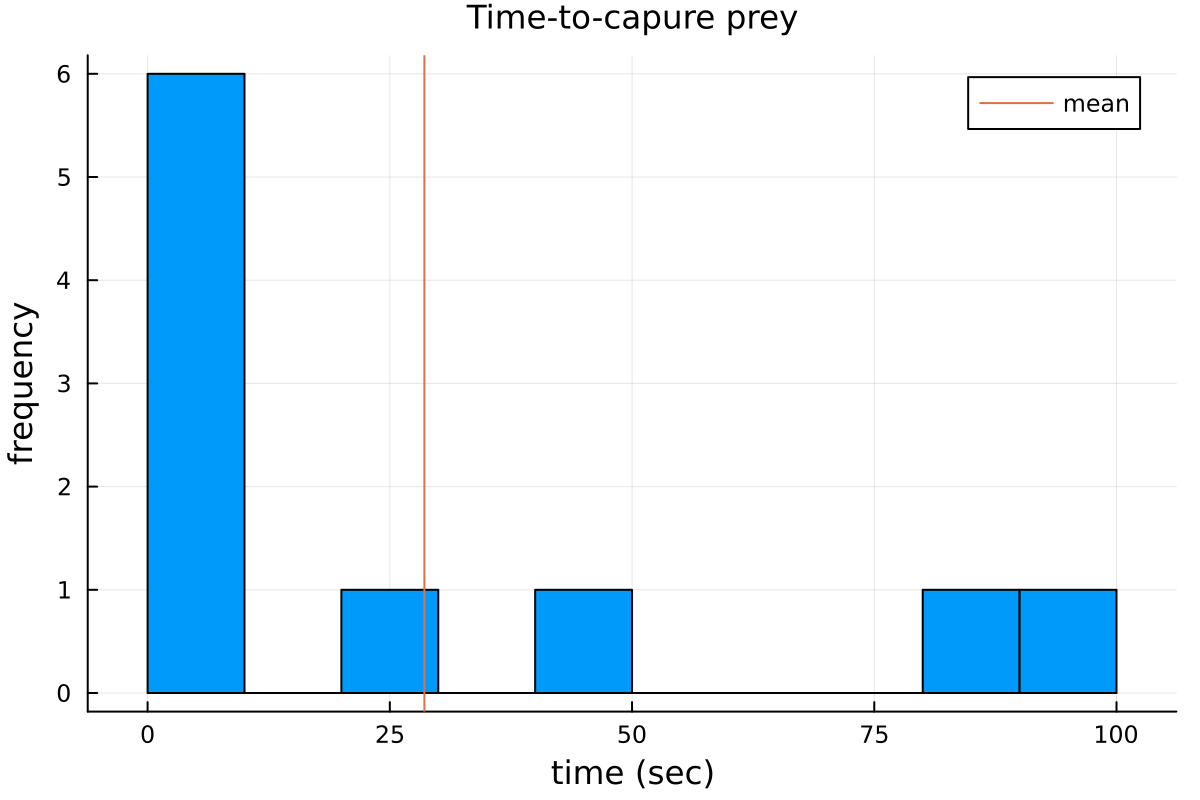

In [4]:
plot(data.time, st = :histogram, nbins = 10, title = "Time-to-capure prey",
    xlab = "time (sec)", ylab = "frequency", lab = false)
plot!([mean(data.time)], st = :vline, lab = "mean")

### Log-likelihood function

Assuming the following model
\begin{equation}
  Y_i \sim Exponential(\theta).
\end{equation}
The parameter $\theta$ represents the mean time-to-capture in the population under
analysis. The log-likelihood function for the observed data is plotted below.

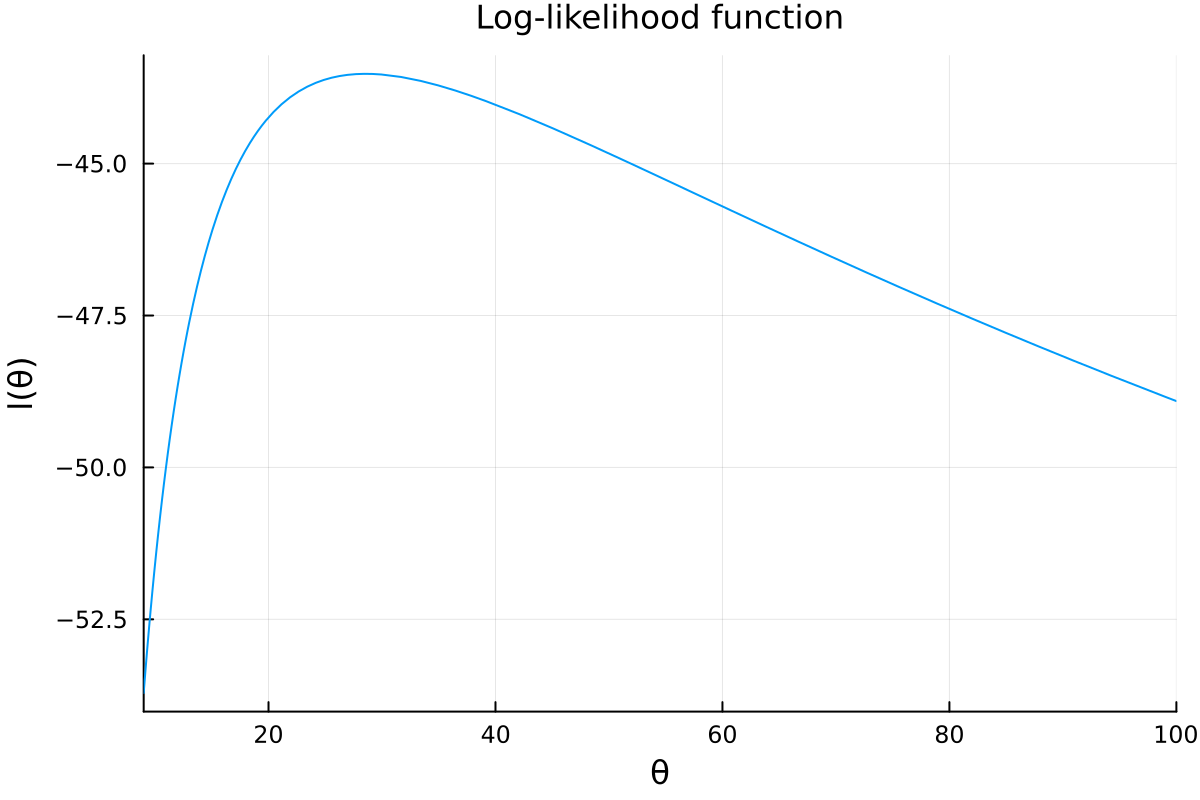

In [5]:
timeloglike(θ) = sum(logpdf.(Exponential(θ), data.time))
plot(timeloglike, xlim = (9, 100), title = "Log-likelihood function",
    xlab = "θ", ylab = "l(θ)", legend = false)

### Compare theoretical model and empirical data

Define a function to compare the empirical data with the theoretical model for a
specific value of the parameter $\theta$.

In [6]:
function plotloglike(θ0)
    p1 = histogram(data.time, nbin = 10, xlim = (0, 150), normalize = true, title = "Comparison",
        label = "Empirical");
    plot!(p1, x -> pdf(Exponential(θ0), x), color = :red, label = "Theoretical")
    p2 = plot(timeloglike, xlim = (9, 100), title = "Log-likelihood function",
        xlab = "θ", ylab = "l(θ)", legend = false);
    scatter!(p2, [θ0], [timeloglike(θ0)], color = :red);
    plot(p1, p2)
end

plotloglike (generic function with 1 method)

The log-likelihood function evaluated at $\theta = 10$ is a low value indicating that
the theoretical model and the observed data do not seem compatible.

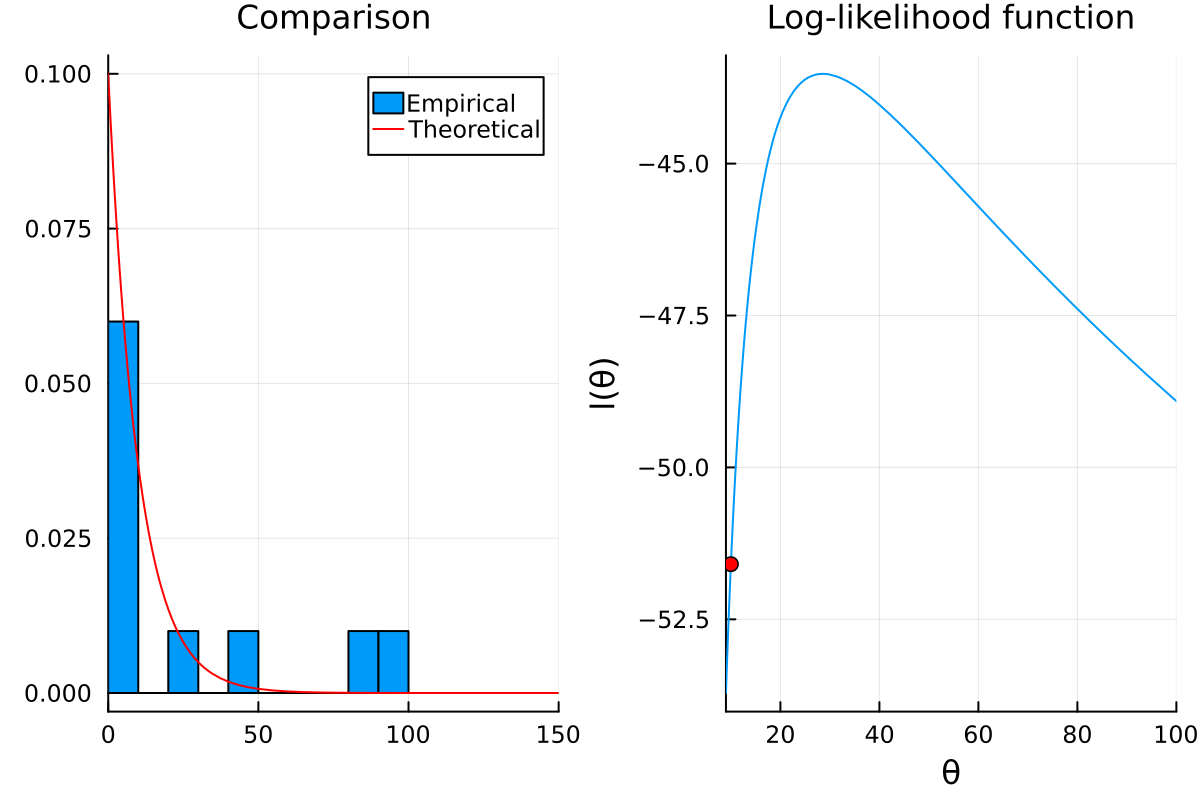

In [7]:
plotloglike(10)

The log-likelihood function evaluated at $\theta = 80$ is a low value indicating that
the theoretical model and the observed data do not seem compatible.

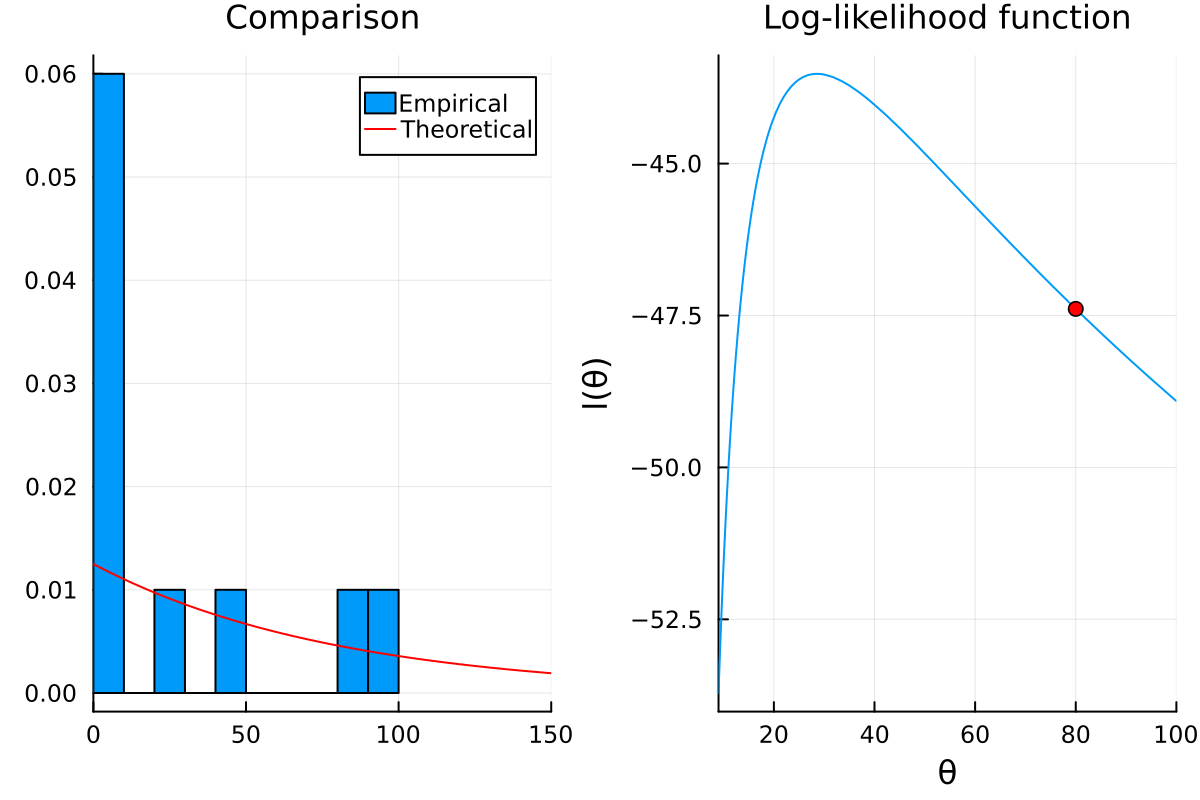

In [8]:
plotloglike(80)

The log-likelihood function evaluated at $\theta = 27$ is a high value indicating that
the theoretical model and the observed data seem more compatible than with other values
for $\theta$.

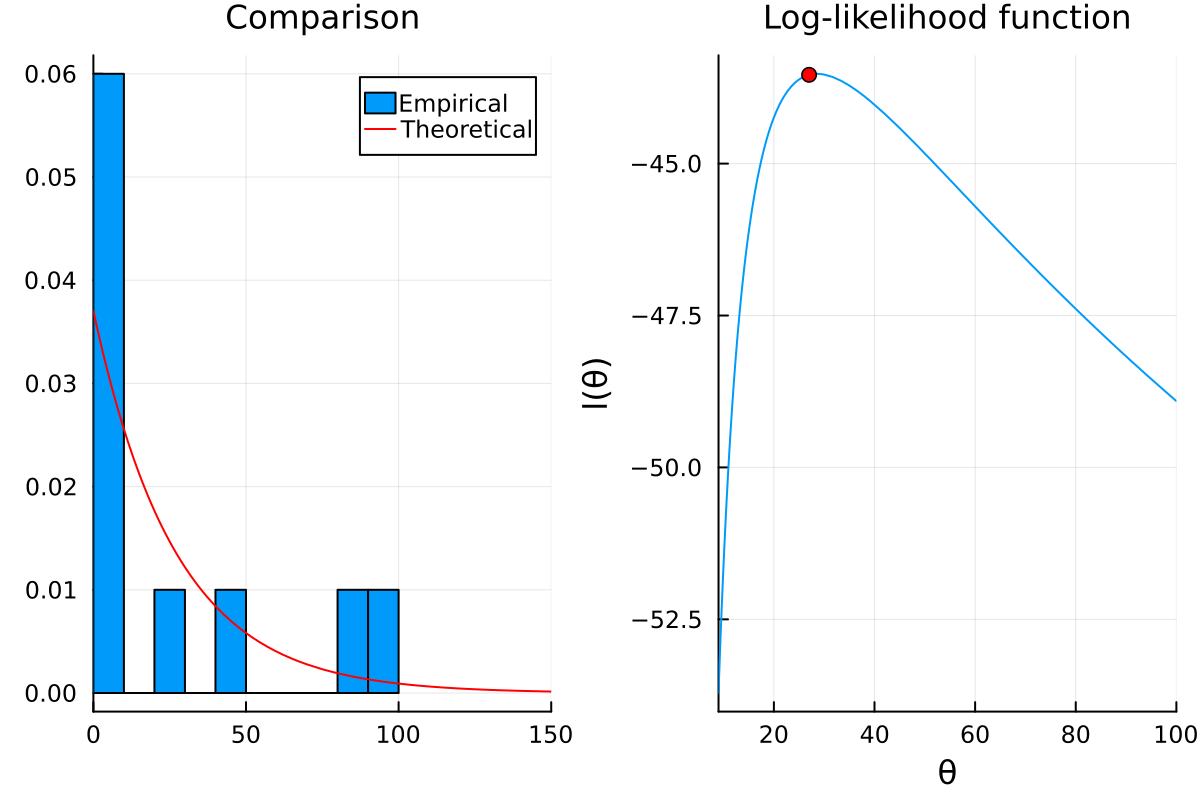

In [9]:
plotloglike(27)

### Maximum likelihood estimator

Obtaining the maximum likelihood estimate analytically.

In [10]:
θ_estimate = mean(data.time)

28.566407292199067

Obtaining the maximum likelihood estimate using a optimization method.

In [11]:
initial = [log(10)]
@time out = optimize(x -> -timeloglike(exp(first(x))), initial, Newton(); autodiff = :forward)
estimate = exp.(Optim.minimizer(out))

  1.105306 seconds (5.35 M allocations: 267.965 MiB, 5.61% gc time, 99.73% compilation time)


1-element Vector{Float64}:
 28.566407292199166

### Confidence interval

In [12]:
Iₒ = ForwardDiff.hessian(x -> timeloglike(first(x)), estimate)
est_var = 1 / (-Iₒ[1,1])

81.60396255838155

In [13]:
α = 0.05
z = quantile(Normal(0,1), 1 - α/2)

1.9599639845400576

In [14]:
[estimate[1] - sqrt(est_var) * z, estimate[1] + sqrt(est_var) * z]

2-element Vector{Float64}:
 10.861089961705225
 46.27172462269311

It might be better to use the deviance to create confidence intervals for this case.

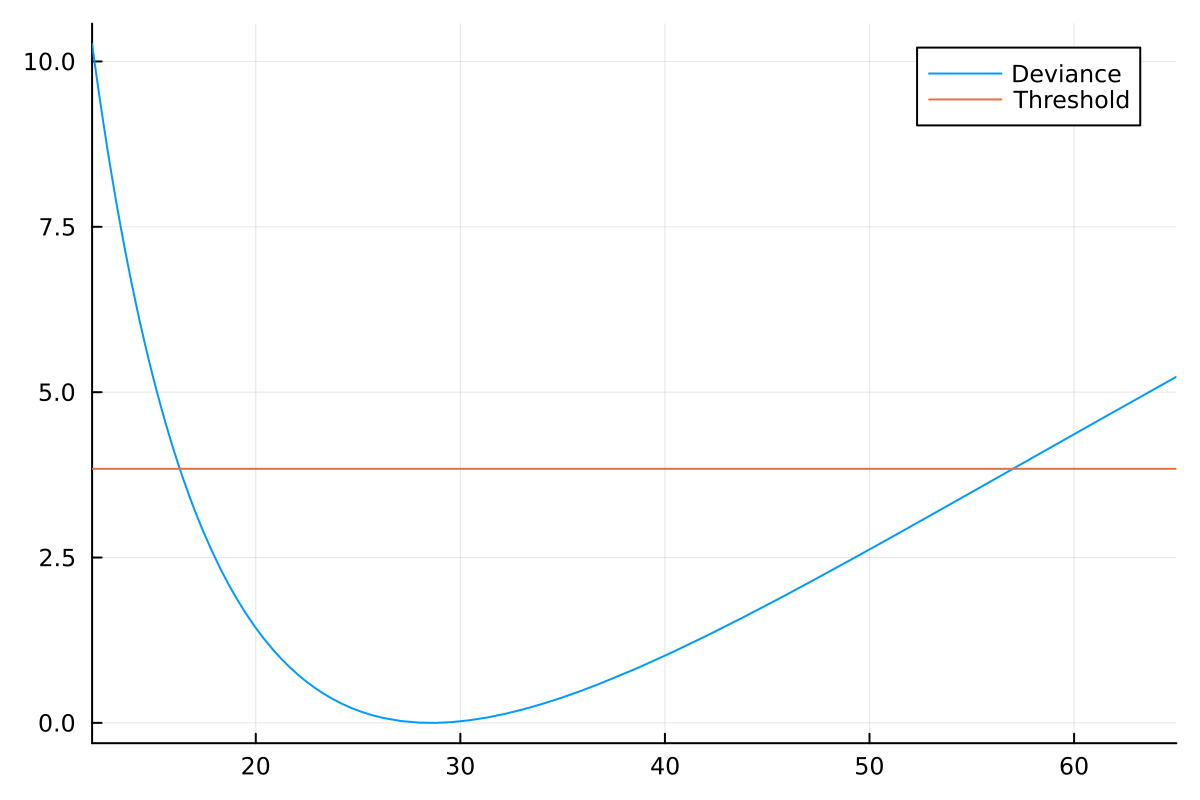

In [15]:
mydeviance(θ) = 2 * (timeloglike(first(estimate)) - timeloglike(θ))
plot(mydeviance, xlim = (12, 65), label = "Deviance")
hline!([quantile(Chisq(1), 1 - α)], label = "Threshold")

### Using GLM package

In [16]:
glm1 = glm(@formula(time ~ 1), data, Gamma(), LogLink())

StatsModels.TableRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Gamma{Float64}, GLM.LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

time ~ 1

Coefficients:
──────────────────────────────────────────────────────────────────────
               Coef.  Std. Error     z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────
(Intercept)  3.35223    0.392323  8.54    <1e-16    2.58329    4.12117
──────────────────────────────────────────────────────────────────────

In [17]:
exp.(coef(glm1))

1-element Vector{Float64}:
 28.56640979020484

In [18]:
confint(glm1)

1×2 Matrix{Float64}:
 2.58329  4.12117

In [19]:
dispersion(glm1.model)

1.2406339948319989

## Time to capture prey with one predictor

### Load packages

In [20]:
using Distributions
using DataFrames
using Plots
using Random
using Optim
using ForwardDiff
using GLM
import CSV
default(dpi = 200, titlefontsize = 11)

### Read data

Simulated data corresponding to the time fur seals need to capture their first prey.

In [21]:
data = CSV.read("../data/simulated/time-to-capture.csv", DataFrame)

10×2 DataFrame
 Row │ age      time
     │ Float64  Float64
─────┼─────────────────────
   1 │ 177.811  20.7883
   2 │ 195.207   5.15748
   3 │ 167.333  49.4457
   4 │ 178.041   9.90466
   5 │ 203.024   0.0770514
   6 │ 163.358  80.4105
   7 │ 186.886   7.51927
   8 │ 170.368  99.2618
   9 │ 181.688   5.60274
  10 │ 189.528   7.49648

Lets obtain some descriptive information about the data.

In [22]:
n = nrow(data)
describe(data)

2×7 DataFrame
 Row │ variable  mean      min          median     max       nmissing  eltype  ⋯
     │ Symbol    Float64   Float64      Float64    Float64   Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ age       181.324   163.358      179.864    203.024          0  Float64 ⋯
   2 │ time       28.5664    0.0770514    8.71196   99.2618         0  Float64
                                                                1 column omitted

Visualize the relationship of time to capture prey and age.

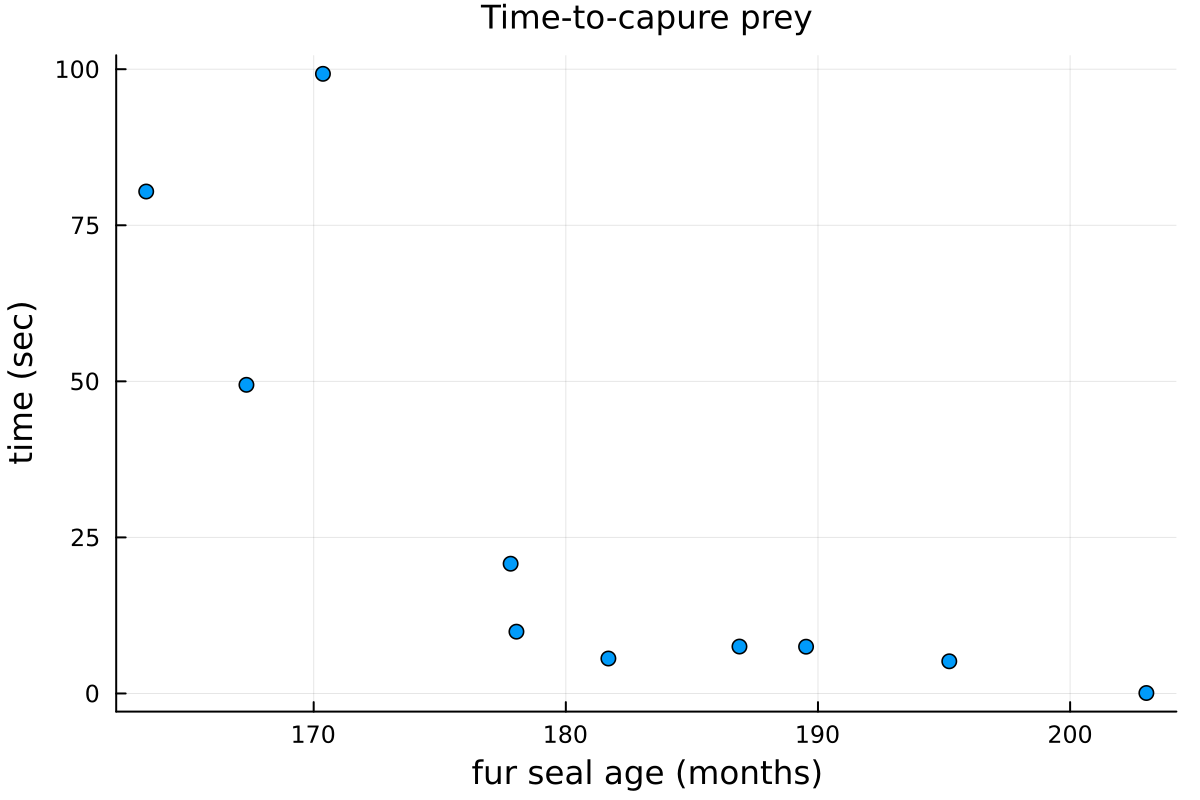

In [23]:
plot(data.age, data.time, st = :scatter, title = "Time-to-capure prey",
    xlab = "fur seal age (months)", ylab = "time (sec)", lab = false)

### Log-likelihood function

Defining the log-likelihood for the more complex model

In [24]:
timeloglike2(θ) = sum(logpdf.(Exponential.(exp.(θ[1] .+ θ[2] * data.age)), data.time))

timeloglike2 (generic function with 1 method)

Evaluate the log-likelihood function in a grid of possible values for the paramters.

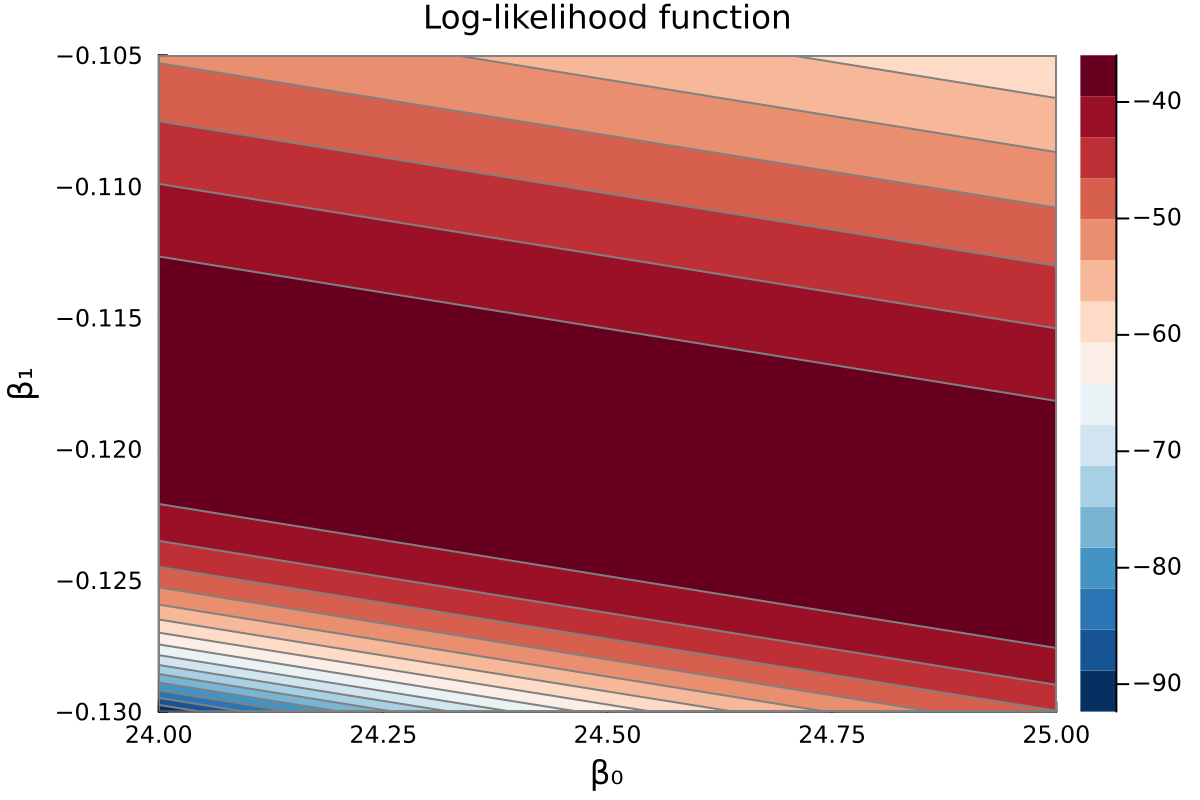

In [25]:
θ1 = range(24, 25, 200)
θ2 = range(-0.13, -0.105, 200)
θgrid = [[i, j] for i in θ1 for j in θ2]
loglikegrid = reshape(timeloglike2.(θgrid), length(θ2), length(θ1))

plot(θ1, θ2, loglikegrid, st = :contour, fill = true,
    color = cgrad(:RdBu, rev = true), linecolor = :gray,
    title = "Log-likelihood function", xlab = "β₀", ylab = "β₁")

### Maximum likelihood estimator

In [26]:
initial = [21.12, -0.1]
out = optimize(x -> -timeloglike2(x), initial, Newton(); autodiff = :forward)
estimate = Optim.minimizer(out)

2-element Vector{Float64}:
 24.455797156131812
 -0.12054384861494652

Interpreting the intercept.

In [27]:
exp(estimate[1])

4.178474493394017e10

In [28]:
print(minimum(data.age))
exp(estimate[1] + estimate[2] * minimum(data.age))

163.35777796684408

117.21641168981857

Interpreting the slope.

In [29]:
exp(estimate[2])

0.8864382174051192

In [30]:
exp(12 * estimate[2])

0.23538655922654472

Visualize the estimated mean

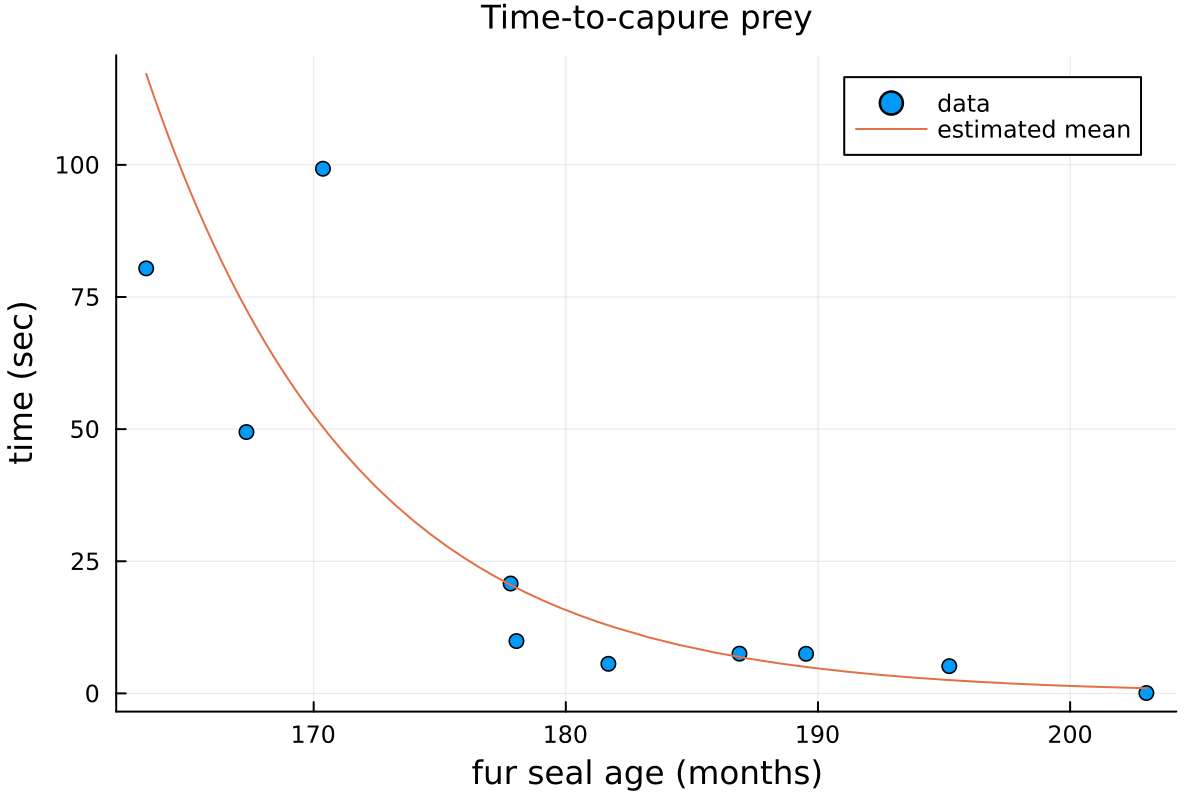

In [31]:
mean_time(age) = exp(estimate[1] + estimate[2] * age)

plot(data.age, data.time, st = :scatter, title = "Time-to-capure prey",
    xlab = "fur seal age (months)", ylab = "time (sec)", lab = "data")
plot!(mean_time, lab = "estimated mean")

### Confidence intervals

H = ForwardDiff.hessian(timeloglike2, estimate)

In [32]:
Iₒ = ForwardDiff.hessian(timeloglike2, estimate)
Σ = inv(-Iₒ)

2×2 Matrix{Float64}:
 28.075     -0.154282
 -0.154282   0.000850861

In [33]:
α = 0.05
z = quantile(Normal(0,1), 1 - α/2)

1.9599639845400576

In [34]:
[estimate[1] - sqrt(Σ[1,1]) * z, estimate[1] + sqrt(Σ[1,1]) * z]

2-element Vector{Float64}:
 14.070754381237782
 34.84083993102584

In [35]:
[estimate[2] - sqrt(Σ[2,2]) * z, estimate[2] + sqrt(Σ[2,2]) * z]

2-element Vector{Float64}:
 -0.17771504815148728
 -0.06337264907840576

### Using GLM package

In [36]:
glm1 = glm(@formula(time ~ age), data, Gamma(), LogLink())

StatsModels.TableRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Gamma{Float64}, GLM.LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

time ~ 1 + age

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  24.4551    3.36999     7.26    <1e-12  17.8501    31.0602
age          -0.12054   0.0185453  -6.50    <1e-10  -0.156888  -0.0841919
─────────────────────────────────────────────────────────────────────────

In [37]:
exp.(coef(glm1))

2-element Vector{Float64}:
 4.1756183308943e10
 0.8864415603114181

In [38]:
confint(glm1)

2×2 Matrix{Float64}:
 17.8501    31.0602
 -0.156888  -0.0841919

In [39]:
dispersion(glm1.model)

0.699750906749806

## Time to capture prey with predictors

### Load packages

In [40]:
using Distributions
using DataFrames
using Chain
using Plots
using Random
using Optim
using ForwardDiff
using GLM
import CSV
default(dpi = 200, titlefontsize = 11)

### Read data

Simulated data corresponding to the time fur seals need to capture their first prey.

In [41]:
data = CSV.read("../data/simulated/time-to-capture.csv", DataFrame)

10×2 DataFrame
 Row │ age      time
     │ Float64  Float64
─────┼─────────────────────
   1 │ 177.811  20.7883
   2 │ 195.207   5.15748
   3 │ 167.333  49.4457
   4 │ 178.041   9.90466
   5 │ 203.024   0.0770514
   6 │ 163.358  80.4105
   7 │ 186.886   7.51927
   8 │ 170.368  99.2618
   9 │ 181.688   5.60274
  10 │ 189.528   7.49648

Lets add some ficticious predictors.

In [42]:
n = nrow(data)
data = @chain begin
    transform(data, (x -> randn(n, 3)))
    rename(["x$i" => "pred$i" for i in 1:3])
end

10×5 DataFrame
 Row │ age      time        pred1      pred2       pred3
     │ Float64  Float64     Float64    Float64     Float64
─────┼─────────────────────────────────────────────────────────
   1 │ 177.811  20.7883     -0.204786  -0.249716    0.458715
   2 │ 195.207   5.15748    -1.62702   -0.260988    0.368568
   3 │ 167.333  49.4457     -0.455333   0.0623065  -1.2192
   4 │ 178.041   9.90466    -1.31846   -1.68797     2.40641
   5 │ 203.024   0.0770514  -0.577552  -1.23432     0.395238
   6 │ 163.358  80.4105      0.281644  -1.56507    -1.03261
   7 │ 186.886   7.51927    -1.09678    1.02496    -0.0570502
   8 │ 170.368  99.2618     -1.26791    1.49255     0.00516005
   9 │ 181.688   5.60274    -0.360594  -0.243616   -0.345123
  10 │ 189.528   7.49648    -0.889141   0.238571    1.36392

Lets obtain some descriptive information about the data.

In [43]:
describe(data)

5×7 DataFrame
 Row │ variable  mean        min          median      max         nmissing  el ⋯
     │ Symbol    Float64     Float64      Float64     Float64     Int64     Da ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ age       181.324     163.358      179.864     203.024            0  Fl ⋯
   2 │ time       28.5664      0.0770514    8.71196    99.2618           0  Fl
   3 │ pred1      -0.751592   -1.62702     -0.733346    0.281644         0  Fl
   4 │ pred2      -0.24233    -1.68797     -0.246666    1.49255          0  Fl
   5 │ pred3       0.234402   -1.2192       0.186864    2.40641          0  Fl ⋯
                                                                1 column omitted

### Log-likelihood function

Defining the log-likelihood for the more complex model

In [44]:
X = Matrix(select(data, :age, r"^pred"))
timeloglike3(θ) = sum(logpdf.(Exponential.(exp.(θ[1] .+ X * θ[2:end])), data.time))

timeloglike3 (generic function with 1 method)

### Maximum likelihood estimator

In [45]:
initial = [21.12, -0.1, 0.0, 0.0, 0.0]
out = optimize(x -> -timeloglike3(x), initial, Newton(); autodiff = :forward)
estimate = Optim.minimizer(out)

5-element Vector{Float64}:
 28.88538089460598
 -0.14787207067168687
 -0.6264679452726766
  0.3416958382520244
  0.04638405248924945

### Confidence intervals

In [46]:
Iₒ = ForwardDiff.hessian(timeloglike3, estimate)
Σ = inv(-Iₒ)

5×5 Matrix{Float64}:
 53.2824     -0.307121     -3.02555    0.0376055     1.02958
 -0.307121    0.00178219    0.0194315  0.000557333  -0.00551927
 -3.02555     0.0194315     0.644463   0.138344      0.0855591
  0.0376055   0.000557333   0.138344   0.172116      0.0299643
  1.02958    -0.00551927    0.0855591  0.0299643     0.182456

In [47]:
α = 0.05
z = quantile(Normal(0,1), 1 - α/2)

1.9599639845400576

In [48]:
[estimate[1] - sqrt(Σ[1,1]) * z, estimate[1] + sqrt(Σ[1,1]) * z]

2-element Vector{Float64}:
 14.578668263414558
 43.192093525797404

In [49]:
[estimate[2] - sqrt(Σ[2,2]) * z, estimate[2] + sqrt(Σ[2,2]) * z]

2-element Vector{Float64}:
 -0.23061391491460675
 -0.06513022642876697

In [50]:
[estimate[3] - sqrt(Σ[3,3]) * z, estimate[3] + sqrt(Σ[3,3]) * z]

2-element Vector{Float64}:
 -2.199897130119137
  0.9469612395737835

In [51]:
[estimate[4] - sqrt(Σ[4,4]) * z, estimate[4] + sqrt(Σ[4,4]) * z]

2-element Vector{Float64}:
 -0.4714322266251629
  1.1548239031292116

In [52]:
[estimate[5] - sqrt(Σ[5,5]) * z, estimate[5] + sqrt(Σ[5,5]) * z]

2-element Vector{Float64}:
 -0.7908120932978611
  0.88358019827636

### Using GLM package

In [53]:
glm1 = glm(@formula(time ~ age + pred1 + pred2 + pred3), data, Gamma(), LogLink())

StatsModels.TableRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Gamma{Float64}, GLM.LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

time ~ 1 + age + pred1 + pred2 + pred3

Coefficients:
──────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  28.8841      4.10614     7.03    <1e-11  20.8362    36.932
age          -0.147868    0.0233593  -6.33    <1e-09  -0.193652  -0.102085
pred1        -0.627274    0.675626   -0.93    0.3532  -1.95148    0.696928
pred2         0.341473    0.318279    1.07    0.2833  -0.282343   0.965289
pred3         0.0460637   0.345263    0.13    0.8939  -0.63064    0.722768
──────────────────────────────────────────────────────────────────────────

In [54]:
exp.(coef(glm1))

5-element Vector{Float64}:
 3.501164653475715e12
 0.8625446856151849
 0.5340457895126702
 1.4070182187167664
 1.0471410841030764

In [55]:
confint(glm1)

5×2 Matrix{Float64}:
 20.8362    36.932
 -0.193652  -0.102085
 -1.95148    0.696928
 -0.282343   0.965289
 -0.63064    0.722768

In [56]:
dispersion(glm1.model)

0.7669785160568544

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*